In [46]:
from pysentimiento import create_analyzer
import os
import pandas as pd

In [ ]:
analyzer = create_analyzer(task="sentiment", lang="en")

In [ ]:
# set folder path
folder_path = "data/"

# get list of files in folder
file_list = os.listdir(folder_path)

# create empty list to hold dataframes
df_list = []

# loop through files in folder
for file in file_list:
    # check if file is a CSV
    if file.endswith('.csv'):
        # read CSV file into a pandas dataframe
        df = pd.read_csv(os.path.join(folder_path, file))
        # append dataframe to list
        df_list.append(df)

# concatenate all dataframes in list into a single dataframe
df = pd.concat(df_list, axis=0, ignore_index=True)

In [ ]:
# data wrangling to ensure justice is replying and addressing to the same person in her utterance

df = pd.merge(df, df[['id', 'speaker_type', 'side']], left_on='reply_to', right_on='id', how='left').drop(['id_y'], axis=1)
df.rename(columns={'id_x': 'id', 'speaker_type_x': 'speaker_type', 'speaker_type_y': 'speaker_type_reply_to', 'side_x': 'side', 'side_y': 'side_reply_to'}, inplace=True)
df = pd.merge(df, df[['id', 'speaker_type', 'side']], left_on='addressing', right_on='id', how='left').drop(['id_y'], axis=1)
df.rename(columns={'id_x': 'id', 'speaker_type_x': 'speaker_type', 'speaker_type_y': 'speaker_type_addressing', 'side_x': 'side', 'side_y': 'side_addressing'}, inplace=True)
df['to_same_speaker'] = df['speaker_type_reply_to'] == df['speaker_type_addressing']
#If one is NaN Leave as True - we can still use it. 
df['to_same_speaker'] = df.apply(lambda x: True if pd.isna(x['speaker_type_reply_to']) or pd.isna(x['speaker_type_addressing']) else x['to_same_speaker'], axis=1)
df['to_same_side'] = df['side_reply_to'] == df['side_addressing']
#If one is NaN Leave as True - we can still use it. 
df['to_same_side'] = df.apply(lambda x: True if pd.isna(x['side_reply_to']) or pd.isna(x['side_addressing']) else x['to_same_side'], axis=1)


In [ ]:
justices = ['votes_side_j__ruth_bader_ginsburg', 'votes_side_j__clarence_thomas', 'votes_side_j__stephen_g_breyer', 'votes_side_j__anthony_m_kennedy', 'votes_side_j__antonin_scalia', 'votes_side_j__john_g_roberts_jr', 'votes_side_j__samuel_a_alito_jr', 'votes_side_j__john_paul_stevens', 'votes_side_j__sonia_sotomayor', 'votes_side_j__david_h_souter', 'votes_side_j__elena_kagan', 'votes_side_j__sandra_day_oconnor', 'votes_side_j__william_h_rehnquist', 'votes_side_j__neil_gorsuch', 'votes_side_j__brett_m_kavanaugh', 'win_side']
justices_names = ['j__ruth_bader_ginsburg', 'j__clarence_thomas', 'j__stephen_g_breyer', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr', 'j__john_paul_stevens', 'j__sonia_sotomayor', 'j__david_h_souter', 'j__elena_kagan', 'j__sandra_day_oconnor', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh', 'win_side']


df = df[df['speaker'].isin(justices_names)]


In [ ]:
# run once, takes long time and save file. The dataset can be loaded from the next cell
df[['neg', 'neu', 'pos']] = df['text'].apply(lambda x: pd.Series(analyzer.predict(x).probas))
df.to_csv('\eda\eda_data\sentiment_judge.csv')



In [50]:
# Start from here, reading the sentiment probabilities
data = pd.read_csv('\eda\eda_data\sentiment_judge.csv')


C:\Users\aupab\AppData\Local\Temp/ipykernel_41364/580024828.py:2: DtypeWarning: Columns (18,61,63,65,67,69,71,73,75) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('sentiment.csv')


In [51]:
majority_baseline = []
accuracies = []

for justice in justices_names:
    df = data.copy(deep=True)
    #filter only for utterances of the speaker
    if justice != 'win_side':
        df = df[df['speaker'].isin([justice])]
        justice = "votes_side_" + justice
    
    df = df[df[justice] != -1]

    df_J_to_r = df[(df['speaker_type'] == 'J') & (df['side_addressing'] == 0) & (df['to_same_side'] == True)]
    df_J_to_r = df_J_to_r[['case_id', 'pos', 'neu', 'neg'] + [justice]]
    df_J_to_p = df[(df['speaker_type'] == 'J') & (df['side_addressing'] == 1) & (df['to_same_side'] == True)]
    df_J_to_p = df_J_to_p[['case_id', 'pos', 'neu', 'neg'] + [justice]]

    df_J_to_r = df_J_to_r.groupby(['case_id'] + [justice])[['pos', 'neu', 'neg']].mean().reset_index()
    df_J_to_p = df_J_to_p.groupby(['case_id'] + [justice])[['pos', 'neu', 'neg']].mean().reset_index()

    df_J_to_r['ratio_r'] = df_J_to_r['pos'] / df_J_to_r['neg'] 
    df_J_to_p['ratio_p'] = df_J_to_p['pos'] / df_J_to_p['neg'] 

    df_final = pd.merge(df_J_to_r, df_J_to_p[['case_id', 'ratio_p']], left_on='case_id', right_on='case_id', how='left')

    df_final['more_pos'] = (df_final['ratio_p'] > df_final['ratio_r']).astype(int)

    count = (df_final['more_pos'] == df_final[justice]).sum()
    majority_baseline.append(df_final[justice].value_counts(normalize = True)[1])
    accuracies.append(count/len(df_final))


In [52]:
transformed_names = []
for i in range(len(justices_names)-1):
    transformed_names.append(justices_names[i].split('__')[1].replace('_', ' ').title())

transformed_names.append('All Justices')

df = pd.DataFrame({'justice': transformed_names, 'baseline_accuracy': majority_baseline, 'prediction_accuracy': accuracies})

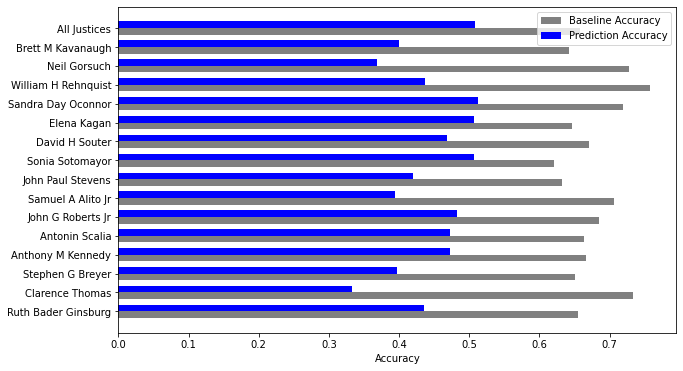

In [53]:
import matplotlib.pyplot as plt
import numpy as np



plt.figure(figsize=(10, 6))
num_judges = len(df)
bar_height = 0.35
indices = np.arange(num_judges)

# Plot 
plt.barh(indices, df['baseline_accuracy'], height=bar_height, color='grey', label='Baseline Accuracy')
plt.barh(indices + bar_height, df['prediction_accuracy'], height=bar_height, color='blue', label='Prediction Accuracy')
plt.yticks(indices + bar_height / 2, df['justice'])
plt.xlabel('Accuracy')
plt.legend()
plt.show()

